In [1]:
import pandas as pd
import urllib
from urllib.request import urlretrieve

In [2]:
post = pd.read_csv("../data/raw/postcode_info.csv")
df = pd.DataFrame()

In [3]:
rent_data = pd.read_excel("https://www.dffh.vic.gov.au/sites/default/files/documents/202209/Moving%20annual%20rent%20by%20suburb%20-%20June%20quarter%202022.xlsx", sheet_name='All properties')
rent = rent_data.drop(index= list(rent_data[rent_data['Unnamed: 1'] == 'Group Total'].index))
rent_data = rent_data.loc[2:]
rent_data.drop(['Moving annual median rent by suburb'],axis=1,inplace=True)
rent_data = rent_data.loc[:,::2]
rent_data.rename(columns={'Unnamed: 1':'suburb'}, inplace = True)
rent_data.head()

,suburb,Unnamed: 3,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13,Unnamed: 15,Unnamed: 17,Unnamed: 19,...,Unnamed: 163,Unnamed: 165,Unnamed: 167,Unnamed: 169,Unnamed: 171,Unnamed: 173,Unnamed: 175,Unnamed: 177,Unnamed: 179,Unnamed: 181
2,Albert Park-Middle Park-West St Kilda,260,260,270,275,275,280,280,290,300,...,600,580,550,550,500,500,500,495,500,520
3,Armadale,200,200,205,210,215,220,225,230,233,...,500,500,500,495,450,440,425,420,430,450
4,Carlton North,260,260,265,270,270,275,280,280,290,...,585,590,590,590,580,575,575,580,580,595
5,Carlton-Parkville,260,260,260,260,260,260,265,270,270,...,404,400,400,395,350,340,330,320,310,319
6,CBD-St Kilda Rd,320,320,320,320,320,320,320,320,320,...,510,495,460,420,380,369,350,350,364,390


In [4]:
#Preprocess suburb
import operator
data_suburb = pd.DataFrame()
sublist = []
for i in rent_data["suburb"]:
    index = rent_data[rent_data.suburb == i].index.tolist()[0]
    if operator.contains(i, "-"):
        j = i.split("-")
        for sub in j:
            sublist.append(sub)
            series = pd.DataFrame(rent_data[index-2:index-1])
            data_suburb = pd.concat([data_suburb, series])
    else:
        sublist.append(i)
        series = pd.DataFrame(rent_data[index-2:index-1])
        data_suburb = pd.concat([data_suburb, series])

data_suburb.insert(0, "suburb new", sublist)
data_suburb.drop(data_suburb.columns[1:2],axis=1,inplace=True)
name = ['suburb']
for i in list(range(2,181,2)):
    name.append(rent[rent.columns.values.tolist()[i]][:1].tolist()[0])
data_suburb.columns = name
data_suburb['postcode'] = ''
df = data_suburb.reset_index(drop=True)

In [5]:
df[df['suburb'] == 'Group Total'].index

Int64Index([32, 62, 82, 100, 121, 143, 154, 165, 176, 187, 195, 202, 227], dtype='int64')

In [6]:
for i in range(len(df)):
    if post[(post['Locality'] == str.upper(df['suburb'][i]))]['Postcode'].to_list() == []:
        df.loc[i,'postcode'] = 0
    else:
        df.loc[i,'postcode'] = post[(post['Locality'] == str.upper(df['suburb'][i])) & (post['State'] == 'VIC')]['Postcode'].to_list()[0]
df=df.drop(df[df['suburb'] == 'Group Total'].index)


In [7]:
#check which suburb cannot be Identified
df[df['postcode'] == 0]

,suburb,Mar 2000,Jun 2000,Sep 2000,Dec 2000,Mar 2001,Jun 2001,Sep 2001,Dec 2001,Mar 2002,...,Jun 2020,Sep 2020,Dec 2020,Mar 2021,Jun 2021,Sep 2021,Dec 2021,Mar 2022,Jun 2022,postcode
2,West St Kilda,260,260,270,275,275,280,280,290,300,...,580,550,550,500,500,500,495,500,520,0
7,CBD,320,320,320,320,320,320,320,320,320,...,495,460,420,380,369,350,350,364,390,0
8,St Kilda Rd,320,320,320,320,320,320,320,320,320,...,495,460,420,380,369,350,350,364,390,0
13,East St Kilda,180,180,180,180,185,190,195,195,200,...,425,420,410,395,385,380,380,380,390,0
51,East Hawthorn,200,201,210,215,220,230,235,235,230,...,440,438,420,400,400,390,380,390,400,0
107,East Brunswick,190,210,210,230,230,240,240,240,250,...,450,450,425,420,410,400,400,400,420,0
120,West Brunswick,140,141,145,150,150,153,160,165,170,...,400,390,380,380,360,350,350,350,360,0
153,Yarra Ranges,150,150,155,155,160,160,165,165,165,...,400,400,400,400,415,420,425,435,450,0
171,Mt Eliza,170,175,180,180,185,190,190,195,200,...,485,496,508,520,545,550,570,590,600,0
173,Mt Martha,170,175,180,180,185,190,190,195,200,...,485,496,508,520,545,550,570,590,600,0


In [8]:
df.loc[2,'postcode'] = 3182
df.loc[7,'postcode'] = 3000
df.loc[8,'postcode'] = 3004
df.loc[13,'postcode'] = 3183
df.loc[51,'postcode'] = 3123
df.loc[107,'postcode'] = 3057
df.loc[120,'postcode'] = 3055
df.loc[153,'postcode'] = 3160
df.loc[171,'postcode'] = 3930
df.loc[173,'postcode'] = 3934
df.loc[181,'postcode'] = 3219
df.loc[198,'postcode'] = 3550
df.loc[223,'postcode'] = 3677

In [9]:
df2 = df.drop(df.columns[1:57], axis=1)
df2

,suburb,Mar 2014,Jun 2014,Sep 2014,Dec 2014,Mar 2015,Jun 2015,Sep 2015,Dec 2015,Mar 2016,...,Jun 2020,Sep 2020,Dec 2020,Mar 2021,Jun 2021,Sep 2021,Dec 2021,Mar 2022,Jun 2022,postcode
0,Albert Park,460,470,480,480,480,495,495,500,520,...,580,550,550,500,500,500,495,500,520,3206
1,Middle Park,460,470,480,480,480,495,495,500,520,...,580,550,550,500,500,500,495,500,520,3206
2,West St Kilda,460,470,480,480,480,495,495,500,520,...,580,550,550,500,500,500,495,500,520,3182
3,Armadale,390,395,390,400,400,399,400,400,400,...,500,500,495,450,440,425,420,430,450,3143
4,Carlton North,510,510,520,520,530,530,530,530,530,...,590,590,590,580,575,575,580,580,595,3054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Traralgon,260,260,265,270,270,270,270,270,270,...,300,310,320,330,340,350,360,360,380,3844
223,Wanagaratta,240,250,250,250,250,250,250,250,260,...,300,300,308,320,330,350,360,370,380,3677
224,Warragul,270,270,271,280,280,280,280,280,290,...,350,360,380,375,380,390,390,400,400,3820
225,Warrnambool,280,280,280,280,280,280,290,290,290,...,340,340,350,350,360,370,380,400,400,3280


In [10]:
for i in range(1, len(df2.columns)-2, 4):
    df2[df2.columns[i][-4:]] = df2[[df2.columns[i], df2.columns[i+1], df2.columns[i+2], df2.columns[i+3]]].mean(axis=1)
    if i  == 33:
        df2[df2.columns[i][-4:]] = df2[[df2.columns[i], df2.columns[i+1]]].mean(axis=1)
df2

,suburb,Mar 2014,Jun 2014,Sep 2014,Dec 2014,Mar 2015,Jun 2015,Sep 2015,Dec 2015,Mar 2016,...,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Albert Park,460,470,480,480,480,495,495,500,520,...,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
1,Middle Park,460,470,480,480,480,495,495,500,520,...,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
2,West St Kilda,460,470,480,480,480,495,495,500,520,...,3182,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
3,Armadale,390,395,390,400,400,399,400,400,400,...,3143,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0
4,Carlton North,510,510,520,520,530,530,530,530,530,...,3054,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Traralgon,260,260,265,270,270,270,270,270,270,...,3844,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0
223,Wanagaratta,240,250,250,250,250,250,250,250,260,...,3677,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0
224,Warragul,270,270,271,280,280,280,280,280,290,...,3820,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0
225,Warrnambool,280,280,280,280,280,280,290,290,290,...,3280,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0


In [11]:
df3 = df2.drop(df2.columns[1:35], axis=1)
df3

,suburb,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Albert Park,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
1,Middle Park,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
2,West St Kilda,3182,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0
3,Armadale,3143,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0
4,Carlton North,3054,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5
...,...,...,...,...,...,...,...,...,...,...,...
222,Traralgon,3844,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0
223,Wanagaratta,3677,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0
224,Warragul,3820,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0
225,Warrnambool,3280,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0


In [16]:
pop = pd.read_csv("../data/raw/population_postcode.csv", index_col=0)
income = pd.read_csv("../data/raw/VIC_yearly_income_poa.csv", index_col=0)
pop

,Postcode,Longitude,Latitude,SA2 name,S/T name,2001,2002,2003,2004,2005,...,population density 2016,population density 2017,population density 2018,population density 2019,population density 2020,population density 2021,population density 2022,population density 2023,population density 2024,population density 2025
0,3002,144.982207,-37.818517,East Melbourne,Victoria,3731,3859,4243,4460,4495,...,1888.0,1895.0,1865.0,1867.0,1854.0,1711.0,1737.0,1762.0,1789.0,1815.0
1,3005,144.950858,-37.824608,Docklands,Victoria,154,926,1913,3089,3779,...,4930.0,5801.0,6433.0,6823.0,6949.0,6642.0,9448.0,13437.0,19111.0,27182.0
2,3008,144.948039,-37.814719,Docklands,Victoria,154,926,1913,3089,3779,...,4930.0,5801.0,6433.0,6823.0,6949.0,6642.0,9448.0,13437.0,19111.0,27182.0
3,3010,144.961351,-37.796152,Parkville,Victoria,5332,5327,5253,5201,5157,...,1974.0,2046.0,2061.0,2074.0,2080.0,1862.0,1894.0,1928.0,1961.0,1996.0
4,3050,144.954581,-37.800324,Parkville,Victoria,5332,5327,5253,5201,5157,...,1974.0,2046.0,2061.0,2074.0,2080.0,1862.0,1894.0,1928.0,1961.0,1996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,3990,145.501279,-38.455399,Wonthaggi - Inverloch,Victoria,17647,17801,17956,18117,18250,...,31.0,32.0,33.0,34.0,35.0,37.0,37.0,38.0,39.0,40.0
588,3991,145.466781,-38.483041,Wonthaggi - Inverloch,Victoria,17647,17801,17956,18117,18250,...,31.0,32.0,33.0,34.0,35.0,37.0,37.0,38.0,39.0,40.0
589,3992,145.534315,-38.569135,Wonthaggi - Inverloch,Victoria,17647,17801,17956,18117,18250,...,31.0,32.0,33.0,34.0,35.0,37.0,37.0,38.0,39.0,40.0
590,3995,145.630713,-38.578071,Wonthaggi - Inverloch,Victoria,17647,17801,17956,18117,18250,...,31.0,32.0,33.0,34.0,35.0,37.0,37.0,38.0,39.0,40.0


In [17]:
income

,Postcode,Longitude,Latitude,SA2 name,Median income in 2014-15,Median income in 2015-16,Median income in 2016-17,Median income in 2017-18,Median income in 2018-19,Median income in 2019-2020,...,Median income in 2024-2025,Median income in 2025-2026,Median weekly income in 2019-2020,Median weekly income in 2020-2021,Median weekly income in 2021-2022,Median weekly income in 2022-2023,Median weekly income in 2023-2024,Median weekly income in 2024-2025,Median weekly income in 2025-2026,Median Income growth rate
0,3000,144.956776,-37.817403,Melbourne,32697,31242,28068,28806,30024,29442.15,...,26697.75,26180.37,566.195192,555.222692,544.462885,533.911538,523.564615,513.418269,503.468654,0.980621
1,8001,144.765920,-38.365017,Melbourne,32697,31242,28068,28806,30024,29442.15,...,26697.75,26180.37,566.195192,555.222692,544.462885,533.911538,523.564615,513.418269,503.468654,0.980621
2,8003,144.957000,-37.818300,Melbourne,32697,31242,28068,28806,30024,29442.15,...,26697.75,26180.37,566.195192,555.222692,544.462885,533.911538,523.564615,513.418269,503.468654,0.980621
3,8006,144.959306,-37.809701,Melbourne,32697,31242,28068,28806,30024,29442.15,...,26697.75,26180.37,566.195192,555.222692,544.462885,533.911538,523.564615,513.418269,503.468654,0.980621
4,8009,144.964531,-37.817201,Melbourne,32697,31242,28068,28806,30024,29442.15,...,26697.75,26180.37,566.195192,555.222692,544.462885,533.911538,523.564615,513.418269,503.468654,0.980621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,3990,145.501279,-38.455399,Wonthaggi - Inverloch,36316,36159,36496,38060,39884,40838.97,...,45967.97,47068.62,785.364808,804.169423,823.424231,843.140192,863.328077,883.999423,905.165769,1.023944
692,3991,145.466781,-38.483041,Wonthaggi - Inverloch,36316,36159,36496,38060,39884,40838.97,...,45967.97,47068.62,785.364808,804.169423,823.424231,843.140192,863.328077,883.999423,905.165769,1.023944
693,3992,145.534315,-38.569135,Wonthaggi - Inverloch,36316,36159,36496,38060,39884,40838.97,...,45967.97,47068.62,785.364808,804.169423,823.424231,843.140192,863.328077,883.999423,905.165769,1.023944
694,3995,145.630713,-38.578071,Wonthaggi - Inverloch,36316,36159,36496,38060,39884,40838.97,...,45967.97,47068.62,785.364808,804.169423,823.424231,843.140192,863.328077,883.999423,905.165769,1.023944


In [13]:
income2 = income.drop(list(income.columns)[1:4],axis=1)
income2 = income2.drop(list(income.columns)[13:],axis=1)
income2 = income2.rename(columns={'Postcode':'postcode'})
income2

,postcode,Median income in 2014-15,Median income in 2015-16,Median income in 2016-17,Median income in 2017-18,Median income in 2018-19,Median income in 2019-2020,Median income in 2020-2021,Median income in 2021-2022,Median income in 2022-2023
0,3000,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
1,8001,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
2,8003,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
3,8006,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
4,8009,32697,31242,28068,28806,30024,29442.15,28871.58,28312.07,27763.40
...,...,...,...,...,...,...,...,...,...,...
691,3990,36316,36159,36496,38060,39884,40838.97,41816.81,42818.06,43843.29
692,3991,36316,36159,36496,38060,39884,40838.97,41816.81,42818.06,43843.29
693,3992,36316,36159,36496,38060,39884,40838.97,41816.81,42818.06,43843.29
694,3995,36316,36159,36496,38060,39884,40838.97,41816.81,42818.06,43843.29


In [14]:
result = pd.merge(df3, income2, how='left', on=['postcode'])
result

,suburb,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022,Median income in 2014-15,Median income in 2015-16,Median income in 2016-17,Median income in 2017-18,Median income in 2018-19,Median income in 2019-2020,Median income in 2020-2021,Median income in 2021-2022,Median income in 2022-2023
0,Albert Park,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,64975,67627,66160.0,66627.0,67518.0,68185.66,68859.93,69540.86,70228.53
1,Middle Park,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,64975,67627,66160.0,66627.0,67518.0,68185.66,68859.93,69540.86,70228.53
2,West St Kilda,3182,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,52654,53562,53066.0,56940.0,59622.0,61531.25,63501.63,65535.11,67633.71
3,Armadale,3143,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0,62089,64169,64075.0,66098.0,69563.0,71580.85,73657.23,75793.84,77992.43
4,Carlton North,3054,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5,53685,54412,54876.0,57240.0,60116.0,61850.24,63634.51,65470.25,67358.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Traralgon,3844,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0,37337,36367,35388.0,38003.0,37232.0,37238.59,37245.18,37251.77,37258.36
211,Wanagaratta,3677,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0,41677,42880,43972.0,45587.0,47525.0,49111.99,50751.98,52446.73,54198.07
212,Warragul,3820,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0,42350,42680,43418.0,45069.0,47709.0,49160.38,50655.92,52196.95,53784.86
213,Warrnambool,3280,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0,42635,43536,44772.0,46945.0,48855.0,50549.58,52302.94,54117.12,55994.22


In [ ]:
pop2 = pop2.drop(list(pop2.columns)[1:14],axis=1)
pop2 = pop2.drop(list(pop2.columns)[9:14],axis=1)
pop2 = pop2.drop(list(pop2.columns)[10:],axis=1)

In [25]:
pop2 = pop.drop(list(pop.columns)[1:35],axis=1)
pop2 = pop2.drop(list(pop2.columns)[-3:],axis=1)

pop2 = pop2.rename(columns={'Postcode':'postcode'})
for i in range(1,len(pop2.columns)):
    pop2 = pop2.rename(columns={pop2.columns[i]: 'pop' + pop2.columns[i]})
pop2

,postcode,poppopulation density 2014,poppopulation density 2015,poppopulation density 2016,poppopulation density 2017,poppopulation density 2018,poppopulation density 2019,poppopulation density 2020,poppopulation density 2021,poppopulation density 2022
0,3002,1853.0,1866.0,1888.0,1895.0,1865.0,1867.0,1854.0,1711.0,1737.0
1,3005,3821.0,4352.0,4930.0,5801.0,6433.0,6823.0,6949.0,6642.0,9448.0
2,3008,3821.0,4352.0,4930.0,5801.0,6433.0,6823.0,6949.0,6642.0,9448.0
3,3010,1862.0,1920.0,1974.0,2046.0,2061.0,2074.0,2080.0,1862.0,1894.0
4,3050,1862.0,1920.0,1974.0,2046.0,2061.0,2074.0,2080.0,1862.0,1894.0
...,...,...,...,...,...,...,...,...,...,...
587,3990,30.0,30.0,31.0,32.0,33.0,34.0,35.0,37.0,37.0
588,3991,30.0,30.0,31.0,32.0,33.0,34.0,35.0,37.0,37.0
589,3992,30.0,30.0,31.0,32.0,33.0,34.0,35.0,37.0,37.0
590,3995,30.0,30.0,31.0,32.0,33.0,34.0,35.0,37.0,37.0


In [16]:
merge = pd.merge(result, pop2, how='left', on=['postcode'])
#print(merge[merge.isnull().T.any()])
merge = merge.dropna()
subu = merge['suburb']
merge = merge[merge.columns[1:]].astype(float)
merge['suburb'] = list(subu)
merge

,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022,...,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019,pop2020,pop2021,pop2022,suburb
0,3206.0,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,...,15592.0,16053.0,16490.0,16495.0,16720.0,17071.0,16942.0,16023.0,16234.0,Albert Park
1,3206.0,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,...,15592.0,16053.0,16490.0,16495.0,16720.0,17071.0,16942.0,16023.0,16234.0,Middle Park
3,3143.0,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0,...,9387.0,9485.0,9619.0,9632.0,9899.0,10036.0,10063.0,9436.0,9479.0,Armadale
4,3054.0,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5,...,8893.0,8964.0,9058.0,9023.0,9020.0,8988.0,8891.0,8295.0,8289.0,Carlton North
5,3053.0,351.75,365.50,373.25,398.00,417.00,431.25,399.75,335.00,314.5,...,17843.0,18983.0,20242.0,20669.0,20869.0,21088.0,20943.0,17198.0,17740.0,Carlton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,3844.0,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0,...,5349.0,5351.0,5371.0,5401.0,5433.0,5469.0,5538.0,5556.0,5550.0,Traralgon
211,3677.0,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0,...,18437.0,18624.0,18940.0,19183.0,19453.0,19600.0,19683.0,19877.0,20027.0,Wanagaratta
212,3820.0,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0,...,18004.0,18466.0,19088.0,19753.0,20478.0,21251.0,22055.0,23080.0,23648.0,Warragul
213,3280.0,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0,...,20930.0,21217.0,21442.0,21676.0,21934.0,22157.0,22379.0,22462.0,22774.0,Warrnambool


In [17]:
len(list(merge[merge.columns[9]]))

166

In [18]:
rent_da = []
income_da = []
pop_da = []
for i in range(1,10):
    rent_da.append(list(merge[merge.columns[i]]))
for j in range(10,19):
    income_da.append(list(merge[merge.columns[j]]))
for k in range(19,28):
    pop_da.append(list(merge[merge.columns[k]]))
rent_da =[float(x) for item in rent_da for x in item]
income_da =[float(x) for item in income_da for x in item]
pop_da =[float(x) for item in pop_da for x in item]


In [19]:
data = {'rent': rent_da, 'income':income_da, 'population': pop_da}
dataset = pd.DataFrame(data)

In [20]:
dataset

,rent,income,population
0,472.50,64975.00,15592.0
1,472.50,64975.00,15592.0
2,393.75,62089.00,9387.0
3,515.00,53685.00,8893.0
4,351.75,39658.00,17843.0
...,...,...,...
1489,370.00,37258.36,5550.0
1490,375.00,54198.07,20027.0
1491,400.00,53784.86,23648.0
1492,400.00,55994.22,22774.0


In [31]:
pop3 = pop.drop(list(pop.columns)[1:44],axis=1)
pop3 = pop3.rename(columns={'Postcode':'postcode'})
pop3

,postcode,population density 2023,population density 2024,population density 2025
0,3002,1762.0,1789.0,1815.0
1,3005,13437.0,19111.0,27182.0
2,3008,13437.0,19111.0,27182.0
3,3010,1928.0,1961.0,1996.0
4,3050,1928.0,1961.0,1996.0
...,...,...,...,...
587,3990,38.0,39.0,40.0
588,3991,38.0,39.0,40.0
589,3992,38.0,39.0,40.0
590,3995,38.0,39.0,40.0


In [22]:
income3 = income.drop(list(income.columns)[1:13],axis=1)
income3 = income3.drop(list(income3.columns)[-8:],axis=1)
income3 = income3.rename(columns={'Postcode':'postcode'})
income3

,postcode,Median income in 2023-2024,Median income in 2024-2025,Median income in 2025-2026
0,3000,27225.36,26697.75,26180.37
1,8001,27225.36,26697.75,26180.37
2,8003,27225.36,26697.75,26180.37
3,8006,27225.36,26697.75,26180.37
4,8009,27225.36,26697.75,26180.37
...,...,...,...,...
691,3990,44893.06,45967.97,47068.62
692,3991,44893.06,45967.97,47068.62
693,3992,44893.06,45967.97,47068.62
694,3995,44893.06,45967.97,47068.62


In [23]:
post = merge.drop(list(merge.columns)[1:],axis=1)
result2 = pd.merge(post, income3, how='left', on=['postcode'])
predict = pd.merge(result2, pop3, how='left', on=['postcode'])
predict

,postcode,Median income in 2023-2024,Median income in 2024-2025,Median income in 2025-2026,pop2023,pop2024,pop2025
0,3206.0,70923.00,71624.34,72332.61,16448.0,16665.0,16885.0
1,3206.0,70923.00,71624.34,72332.61,16448.0,16665.0,16885.0
2,3143.0,80254.79,82582.78,84978.30,9523.0,9567.0,9611.0
3,3054.0,69302.14,71301.39,73358.31,8283.0,8277.0,8271.0
4,3053.0,38085.47,37926.38,37767.95,18299.0,18876.0,19471.0
...,...,...,...,...,...,...,...
161,3844.0,37264.95,37271.54,37278.13,5544.0,5538.0,5532.0
162,3677.0,56007.90,57878.16,59810.88,20178.0,20330.0,20483.0
163,3820.0,55421.08,57107.08,58844.37,24230.0,24827.0,25438.0
164,3280.0,57936.43,59946.01,62025.30,23090.0,23410.0,23735.0


In [24]:
income_da2 = []
pop_da2 = []
for j in range(1,4):
    income_da2.append(list(predict[predict.columns[j]]))

for k in range(4,7):
    pop_da2.append(list(predict[predict.columns[k]]))
income_da2 =[float(x) for item in income_da2 for x in item]
pop_da2 =[float(x) for item in pop_da2 for x in item]

In [25]:
index = []
index.append(predict['postcode'].tolist()*3)
predict2 = {'index': index[0], 'income': income_da2, 'population':pop_da2}
pt = pd.DataFrame(predict2)
pt = pt.set_index('index')
pt

,income,population
index,,
3206.0,70923.00,16448.0
3206.0,70923.00,16448.0
3143.0,80254.79,9523.0
3054.0,69302.14,8283.0
3053.0,38085.47,18299.0
...,...,...
3844.0,37278.13,5532.0
3677.0,59810.88,20483.0
3820.0,58844.37,25438.0


In [26]:
pt_23 = pt.iloc[0:166]
pt_24 = pt.iloc[166:332]
pt_25 = pt.iloc[332:498]


## Linear Regression

In [92]:
from sklearn.model_selection import train_test_split #这里是引用了交叉验证
from sklearn.linear_model import LinearRegression  #线性回归
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
X = dataset.iloc[:, 1:3].values
y = dataset.iloc[:, 0].values
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=100)
linreg = LinearRegression()
model=linreg.fit(X_train, y_train)
print (model)
# 训练后模型截距
print (linreg.intercept_)
# 训练后模型权重（特征个数无变化）
print (linreg.coef_)

LinearRegression()
84.22257937412354
[0.00522627 0.00210872]


In [93]:

y_pred = model.predict(X_test)


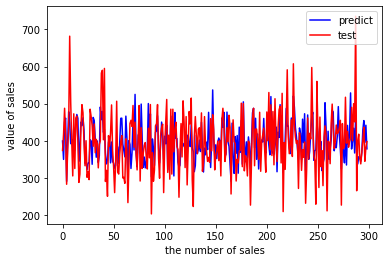

In [94]:

    #做ROC曲线
plt.figure()
plt.plot(range(len(y_pred)),y_pred,'b',label="predict")
plt.plot(range(len(y_pred)),y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of sales")
plt.ylabel('value of sales')
plt.show()

In [95]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 49.69508882251517
Mean Squared Error: 3958.3877127902088
Root Mean Squared Error: 62.91571912320647


## Random Forest

In [27]:
import pandas as pd
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
import multiprocessing
from multiprocessing import Process,Queue,Pool
from sklearn.ensemble import RandomForestRegressor

In [28]:
# 因变量：汽油消耗量
X = dataset.iloc[:, 1:3].values
y = dataset.iloc[:, 0].values

# 将数据分为训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [96]:
# 训练随机森林解决回归问题
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=50, bootstrap = True, max_depth = 25, min_samples_leaf = 3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
random_forest_error=y_pred-y_test

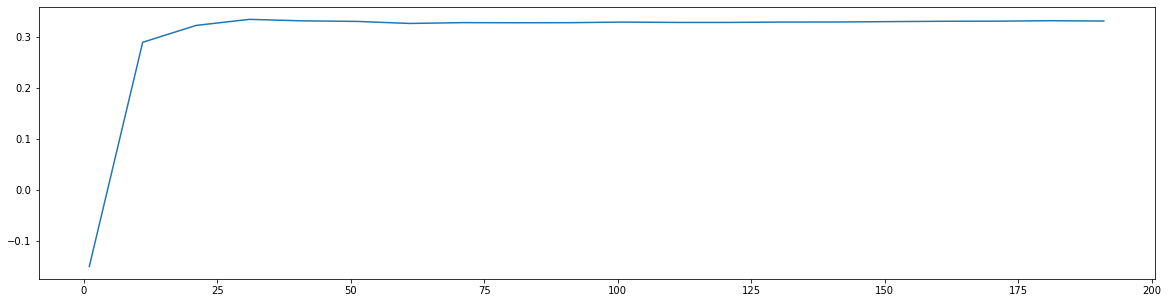

In [97]:
from sklearn.model_selection import cross_val_score
scorel = []
for i in range(0,200,10):
    rfc = RandomForestRegressor(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,X,y,cv=5).mean()
    scorel.append(score)

#print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

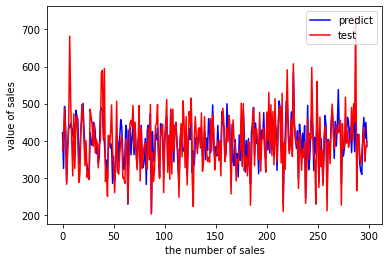

In [98]:

plt.figure()
plt.plot(range(len(y_pred)),y_pred,'b',label="predict")
plt.plot(range(len(y_pred)),y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of sales")
plt.ylabel('value of sales')
plt.show()

In [99]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 39.98462547110079
Mean Squared Error: 2815.073491126838
Root Mean Squared Error: 53.05726614825568


In [100]:
from pandas import DataFrame
import csv
result = {'postcode': pt.iloc[166:332].index, '2024_pre': regressor.predict(pt_24)}
df_24 = DataFrame(result).reset_index()
print(df_24)

     index  postcode    2024_pre
0        0    3206.0  565.471238
1        1    3206.0  565.471238
2        2    3143.0  465.391984
3        3    3054.0  490.290375
4        4    3053.0  331.020135
..     ...       ...         ...
161    161    3844.0  313.263305
162    162    3677.0  403.462328
163    163    3820.0  438.050123
164    164    3280.0  436.031653
165    165    3689.0  396.593335

[166 rows x 3 columns]


/Users/liuyiqun/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [101]:
from pandas import DataFrame
import csv
result = {'postcode': pt.iloc[332:498].index, '2025_pre': regressor.predict(pt_25)}
df_25 = DataFrame(result).reset_index()
print(df_25)

     index  postcode    2025_pre
0        0    3206.0  600.537781
1        1    3206.0  600.537781
2        2    3143.0  466.259127
3        3    3054.0  489.276343
4        4    3053.0  333.460750
..     ...       ...         ...
161    161    3844.0  313.263305
162    162    3677.0  416.302931
163    163    3820.0  456.530516
164    164    3280.0  470.418938
165    165    3689.0  421.617639

[166 rows x 3 columns]


/Users/liuyiqun/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [102]:
from pandas import DataFrame
import csv
result = {'postcode': pt.iloc[0:166].index, '2023_pre': regressor.predict(pt_23)}
df_23 = DataFrame(result).reset_index()
print(df_23)

/Users/liuyiqun/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


     index  postcode    2023_pre
0        0    3206.0  537.524245
1        1    3206.0  537.524245
2        2    3143.0  462.858234
3        3    3054.0  489.485218
4        4    3053.0  333.436488
..     ...       ...         ...
161    161    3844.0  313.263305
162    162    3677.0  418.365692
163    163    3820.0  429.870181
164    164    3280.0  426.247153
165    165    3689.0  397.458687

[166 rows x 3 columns]


In [103]:
df_22 = merge.drop(merge.columns[1:9], axis=1)
df_22 = df_22.drop(df_22.columns[2:], axis=1).reset_index()
df_22

,index,postcode,2022
0,0,3206.0,510.0
1,1,3206.0,510.0
2,3,3143.0,440.0
3,4,3054.0,587.5
4,5,3053.0,314.5
...,...,...,...
161,210,3844.0,370.0
162,211,3677.0,375.0
163,212,3820.0,400.0
164,213,3280.0,400.0


In [104]:
df_23['2023_rate'] = (df_23['2023_pre'] - df_22['2022'])/df_22['2022']
df_23


,index,postcode,2023_pre,2023_rate
0,0,3206.0,537.524245,0.053969
1,1,3206.0,537.524245,0.053969
2,2,3143.0,462.858234,0.051951
3,3,3054.0,489.485218,-0.166834
4,4,3053.0,333.436488,0.060211
...,...,...,...,...
161,161,3844.0,313.263305,-0.153342
162,162,3677.0,418.365692,0.115642
163,163,3820.0,429.870181,0.074675
164,164,3280.0,426.247153,0.065618


In [105]:
df_24['2024_rate'] = (df_24['2024_pre'] - df_23['2023_pre'])/df_23['2023_pre']
df_24

,index,postcode,2024_pre,2024_rate
0,0,3206.0,565.471238,0.051992
1,1,3206.0,565.471238,0.051992
2,2,3143.0,465.391984,0.005474
3,3,3054.0,490.290375,0.001645
4,4,3053.0,331.020135,-0.007247
...,...,...,...,...
161,161,3844.0,313.263305,0.000000
162,162,3677.0,403.462328,-0.035623
163,163,3820.0,438.050123,0.019029
164,164,3280.0,436.031653,0.022955


In [106]:
df_25['2025_22_rate'] = (df_25['2025_pre'] - df_22['2022'])/df_22['2022']
df_25

,index,postcode,2025_pre,2025_22_rate
0,0,3206.0,600.537781,0.177525
1,1,3206.0,600.537781,0.177525
2,2,3143.0,466.259127,0.059680
3,3,3054.0,489.276343,-0.167189
4,4,3053.0,333.460750,0.060289
...,...,...,...,...
161,161,3844.0,313.263305,-0.153342
162,162,3677.0,416.302931,0.110141
163,163,3820.0,456.530516,0.141326
164,164,3280.0,470.418938,0.176047


In [107]:
sub = merge.drop(merge.columns[1:28], axis=1).reset_index(drop = True).reset_index()
sub

,index,postcode,suburb
0,0,3206.0,Albert Park
1,1,3206.0,Middle Park
2,2,3143.0,Armadale
3,3,3054.0,Carlton North
4,4,3053.0,Carlton
...,...,...,...
161,161,3844.0,Traralgon
162,162,3677.0,Wanagaratta
163,163,3820.0,Warragul
164,164,3280.0,Warrnambool


In [108]:
rate_23 = pd.merge(df_23, sub, how = 'left', on = ['index','postcode'])
rate_23.sort_values(by='2023_rate',ascending=False).head(10)


,index,postcode,2023_pre,2023_rate,suburb
36,36,3122.0,515.379227,0.451772,Hawthorn
82,82,3039.0,586.321582,0.407735,Moonee Ponds
88,88,3088.0,573.781009,0.374326,Greensborough
5,5,3052.0,427.641917,0.359752,Parkville
135,135,3350.0,463.588681,0.324539,Ballarat
47,47,3163.0,519.511845,0.323597,Carnegie
57,57,3163.0,519.511845,0.306948,Murrumbeena
10,10,3183.0,501.771688,0.303303,East St Kilda
48,48,3162.0,519.511845,0.282745,Caulfield
95,95,3084.0,540.005897,0.278120,Heidelberg


In [109]:
rate_24 = pd.merge(df_24, sub, how = 'left', on = ['index','postcode'])
rate_24.sort_values(by='2024_rate',ascending=False).head(10)

,index,postcode,2024_pre,2024_rate,suburb
152,152,3300.0,470.107270,0.234164,Hamilton
66,66,3023.0,451.432726,0.210566,Deer Park
89,89,3099.0,459.060120,0.198946,Hurstbridge
156,156,3840.0,406.157679,0.161328,Morwell
118,118,3174.0,375.433975,0.136154,Noble Park
95,95,3084.0,606.767750,0.123632,Heidelberg
86,86,3429.0,493.270106,0.113525,Sunbury
101,101,3073.0,402.593726,0.104968,Reservoir
102,102,3074.0,402.593726,0.104968,Thomastown
116,116,3802.0,396.842874,0.095173,Endeavour Hills


In [113]:
rate_25 = pd.merge(df_25, sub, how = 'left', on = ['index','postcode'])
rate_25['postcode'] = rate_25['postcode'].astype(int)

In [115]:
rate_25.sort_values(by='2025_22_rate',ascending=False).head(10)

,index,postcode,2025_pre,2025_22_rate,suburb
152,152,3300,482.633322,0.556882,Hamilton
36,36,3122,540.005897,0.521143,Hawthorn
5,5,3052,475.691563,0.512533,Parkville
88,88,3088,615.886314,0.475177,Greensborough
86,86,3429,572.401664,0.449118,Sunbury
95,95,3084,598.568723,0.416731,Heidelberg
10,10,3183,535.315516,0.390430,East St Kilda
82,82,3039,577.232271,0.385912,Moonee Ponds
156,156,3840,387.304159,0.358962,Morwell
137,137,3357,490.285100,0.343247,Buninyong
